In [1]:
import pandas as pd


adress = pd.read_csv("D:\\M2 SISE\\Python Machine Learning\\Projet\\Performance_Energetique\\Data\\adresses-69.csv", sep=";")
adress.info()

C:\Users\karam\AppData\Local\Temp\ipykernel_6764\3486045386.py:4: DtypeWarning: Columns (9,16) have mixed types. Specify dtype option on import or set low_memory=False.
  adress = pd.read_csv("D:\\M2 SISE\\Python Machine Learning\\Projet\\Performance_Energetique\\Data\\adresses-69.csv", sep=";")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348195 entries, 0 to 348194
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           348195 non-null  object 
 1   id_fantoir                   327324 non-null  object 
 2   numero                       348195 non-null  int64  
 3   rep                          25512 non-null   object 
 4   nom_voie                     348195 non-null  object 
 5   code_postal                  348195 non-null  int64  
 6   code_insee                   348195 non-null  int64  
 7   nom_commune                  348195 non-null  object 
 8   code_insee_ancienne_commune  28293 non-null   float64
 9   nom_ancienne_commune         28293 non-null   object 
 10  x                            348195 non-null  float64
 11  y                            348195 non-null  float64
 12  lon                          348195 non-null  float64
 13 

In [2]:
adress.head()

,id,id_fantoir,numero,rep,nom_voie,code_postal,code_insee,nom_commune,code_insee_ancienne_commune,nom_ancienne_commune,...,lat,type_position,alias,nom_ld,libelle_acheminement,nom_afnor,source_position,source_nom_voie,certification_commune,cad_parcelles
0,69002_x415an_00003,NaN,3,NaN,Route de Matour,69790,69002,Aigueperse,NaN,NaN,...,46.277603,entrée,NaN,NaN,AIGUEPERSE,ROUTE DE MATOUR,commune,commune,1,NaN
1,69002_x415an_00111,NaN,111,NaN,Route de Matour,69790,69002,Aigueperse,NaN,NaN,...,46.278509,entrée,NaN,NaN,AIGUEPERSE,ROUTE DE MATOUR,commune,commune,1,NaN
2,69002_x415an_00165,NaN,165,NaN,Route de Matour,69790,69002,Aigueperse,NaN,NaN,...,46.278966,entrée,NaN,NaN,AIGUEPERSE,ROUTE DE MATOUR,commune,commune,1,NaN
3,69002_x415an_01148,NaN,1148,NaN,Route de Matour,69790,69002,Aigueperse,NaN,NaN,...,46.287092,entrée,NaN,NaN,AIGUEPERSE,ROUTE DE MATOUR,commune,commune,1,NaN
4,69002_wit9km_00007,NaN,7,NaN,Chemin des Dalhias,69790,69002,Aigueperse,NaN,NaN,...,46.276468,entrée,NaN,NaN,AIGUEPERSE,CHEMIN DES DALHIAS,commune,commune,1,NaN


In [3]:
adress.isna().sum().sort_values(ascending=False).head(100)

alias                          348195
nom_ld                         335051
rep                            322683
nom_ancienne_commune           319902
code_insee_ancienne_commune    319902
cad_parcelles                  300706
type_position                   32934
id_fantoir                      20871
code_insee                          0
nom_voie                            0
numero                              0
id                                  0
code_postal                         0
x                                   0
nom_commune                         0
lat                                 0
lon                                 0
y                                   0
libelle_acheminement                0
nom_afnor                           0
source_position                     0
source_nom_voie                     0
certification_commune               0
dtype: int64

In [4]:
dpe_existant = pd.read_csv("D:\\M2 SISE\\Python Machine Learning\\Projet\\Performance_Energetique\\Data\\dpe-v2-logements-existants.csv", sep=",")
dpe_existant.head()

C:\Users\karam\AppData\Local\Temp\ipykernel_6764\986440580.py:1: DtypeWarning: Columns (12,48,190,191,192,193) have mixed types. Specify dtype option on import or set low_memory=False.
  dpe_existant = pd.read_csv("D:\\M2 SISE\\Python Machine Learning\\Projet\\Performance_Energetique\\Data\\dpe-v2-logements-existants.csv", sep=",")


,N°DPE,Date_réception_DPE,Date_établissement_DPE,Date_visite_diagnostiqueur,Modèle_DPE,N°_DPE_remplacé,Date_fin_validité_DPE,Version_DPE,N°_DPE_immeuble_associé,Appartement_non_visité_(0/1),...,Type_générateur_froid,Surface_climatisée,Type_énergie_climatisation,Catégorie_ENR,Electricité_PV_autoconsommée,Système_production_électricité_origine_renouvelable,Présence_production_PV_(0/1),Production_électricité_PV_(kWhep/an),Surface_totale_capteurs_photovoltaïque,Nombre_module
0,2369E1626603K,2023-05-17,2023-05-16,2023-05-15,DPE 3CL 2021 méthode logement,NaN,2033-05-15,2.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,2469E2448797H,2024-07-06,2024-07-05,2024-07-03,DPE 3CL 2021 méthode logement,NaN,2034-07-04,2.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,2469E1154509Z,2024-03-29,2024-03-28,2024-03-28,DPE 3CL 2021 méthode logement,NaN,2034-03-27,2.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,2269E1396880W,2022-06-22,2022-06-21,2022-06-20,DPE 3CL 2021 méthode logement,NaN,2032-06-20,2.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,2269E1396877T,2022-06-22,2022-06-21,2022-06-20,DPE 3CL 2021 méthode logement,NaN,2032-06-20,2.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [5]:
dpe_neuf = pd.read_csv("D:\\M2 SISE\\Python Machine Learning\\Projet\\Performance_Energetique\\Data\\dpe-v2-logements-neufs.csv", sep=",")
dpe_neuf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2851 entries, 0 to 2850
Columns: 220 entries, N°DPE to Conso_5_usages_é_finale_énergie_n°1
dtypes: float64(176), int64(5), object(39)
memory usage: 4.8+ MB


In [6]:
dpe_neuf.head()

,N°DPE,Date_réception_DPE,Date_établissement_DPE,Date_visite_diagnostiqueur,Modèle_DPE,N°_DPE_remplacé,Date_fin_validité_DPE,Version_DPE,N°_DPE_immeuble_associé,Appartement_non_visité_(0/1),...,Présence_production_PV_(0/1),Production_électricité_PV_kWh,Production_électricité_PV_kWh/m²,Surface_totale_capteurs_photovoltaïque,Nombre_module,Type_énergie_principale_chauffage,Type_énergie_principale_ECS,Déperditions_totales_logement,Déperditions_totales_bâtiment,Conso_5_usages_é_finale_énergie_n°1
0,2469N0892797M,2024-03-12,2024-03-11,2024-03-10,DPE NEUF logement : RT2012,NaN,2034-03-10,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,Électricité,NaN,NaN,NaN,2053.5
1,2469N0892783Y,2024-03-12,2024-03-11,2024-03-10,DPE NEUF logement : RT2012,NaN,2034-03-10,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,Électricité,NaN,NaN,NaN,2011.2
2,2469N0892780V,2024-03-12,2024-03-11,2024-03-10,DPE NEUF logement : RT2012,NaN,2034-03-10,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,Électricité,NaN,NaN,NaN,2408.2
3,2469N0892802R,2024-03-12,2024-03-11,2024-03-10,DPE NEUF logement : RT2012,NaN,2034-03-10,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,Électricité,NaN,NaN,NaN,2092.5
4,2469N2757372X,2024-07-30,2024-07-29,2024-07-07,DPE NEUF logement : RT2012,NaN,2034-07-28,2.4,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,Électricité,NaN,NaN,NaN,3042.7


In [7]:
dpe_existant.shape

(16069, 242)

In [8]:
dpe_existant.isna().sum().sort_values(ascending=False).head(100)

N°_RPLS_logement                                               16069
Facteur_couverture_solaire_saisi_installation_chauffage_n°1    16069
Description_générateur_ECS_n°2                                 16069
Conso_é_finale_générateur_ECS_n°2                              16069
COP_générateur_ECS_n°2                                         16069
                                                               ...  
Emission_GES_5_usages_énergie_n°2                               6585
Inertie_lourde_(0/1)                                            6368
Isolation_toiture_(0/1)                                         6258
Logement_traversant_(0/1)                                       6144
Protection_solaire_exterieure_(0/1)                             6144
Length: 100, dtype: int64

In [9]:
dpe_neuf.shape

(2851, 220)

In [10]:
dpe_neuf.isna().sum().sort_values(ascending=False).head(100)

N°_immatriculation_copropriété                         2851
Typologie_logement                                     2851
Surface_tertiaire_immeuble                             2851
N°_RPLS_logement                                       2851
Classe_inertie_bâtiment                                2851
                                                       ... 
Production_électricité_PV_kWh/m²                       2851
Présence_production_PV_(0/1)                           2851
Système_production_électricité_origine_renouvelable    2851
Conso_refroidissement_annuel                           2851
Déperditions_murs                                      2837
Length: 100, dtype: int64

In [11]:
dpe_neuf_no_empty_columns = dpe_neuf.dropna(axis=1, how='all')
dpe_existant_no_empty_columns = dpe_existant.dropna(axis=1, how='all')

In [12]:
dpe_existant["Logement"] = "ancien"
dpe_neuf["Logement"] = "neuf"

In [13]:
dpe_neuf["Année_construction"] = 2024

In [14]:
common_columns = dpe_existant.columns.intersection(dpe_neuf.columns)
common_columns = common_columns.to_list()

In [15]:
df_concat = pd.concat([dpe_existant, dpe_neuf], join='inner', ignore_index=True)
df_concat

,N°DPE,Date_réception_DPE,Date_établissement_DPE,Date_visite_diagnostiqueur,Modèle_DPE,N°_DPE_remplacé,Date_fin_validité_DPE,Version_DPE,N°_DPE_immeuble_associé,Appartement_non_visité_(0/1),...,Conso_refroidissement_annuel,Type_générateur_froid,Surface_climatisée,Catégorie_ENR,Electricité_PV_autoconsommée,Système_production_électricité_origine_renouvelable,Présence_production_PV_(0/1),Surface_totale_capteurs_photovoltaïque,Nombre_module,Logement
0,2369E1626603K,2023-05-17,2023-05-16,2023-05-15,DPE 3CL 2021 méthode logement,NaN,2033-05-15,2.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ancien
1,2469E2448797H,2024-07-06,2024-07-05,2024-07-03,DPE 3CL 2021 méthode logement,NaN,2034-07-04,2.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ancien
2,2469E1154509Z,2024-03-29,2024-03-28,2024-03-28,DPE 3CL 2021 méthode logement,NaN,2034-03-27,2.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ancien
3,2269E1396880W,2022-06-22,2022-06-21,2022-06-20,DPE 3CL 2021 méthode logement,NaN,2032-06-20,2.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ancien
4,2269E1396877T,2022-06-22,2022-06-21,2022-06-20,DPE 3CL 2021 méthode logement,NaN,2032-06-20,2.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ancien
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18915,2469N2622948T,2024-07-19,2024-07-18,2024-07-07,DPE NEUF logement : RT2012,NaN,2034-07-17,2.4,NaN,0.0,...,NaN,NaN,NaN,pompe à chaleur,NaN,NaN,NaN,NaN,NaN,neuf
18916,2469N1847972Z,2024-05-27,2024-05-14,2024-05-14,DPE NEUF logement : RT2012,NaN,2034-05-13,2.3,NaN,0.0,...,NaN,NaN,NaN,pompe à chaleur,NaN,NaN,NaN,NaN,NaN,neuf
18917,2469N1761971G,2024-05-20,2024-05-19,2024-05-14,DPE NEUF logement : RT2012,NaN,2034-05-18,2.3,NaN,0.0,...,NaN,NaN,NaN,pompe à chaleur,NaN,NaN,NaN,NaN,NaN,neuf
18918,2469N2286221S,2024-06-25,2024-05-19,2024-05-14,DPE NEUF logement : RT2012,NaN,2034-05-18,2.3,NaN,0.0,...,NaN,NaN,NaN,pompe à chaleur,NaN,NaN,NaN,NaN,NaN,neuf


In [16]:
df_concat["Annee_reception_DPE"] = pd.to_datetime(df_concat['Date_réception_DPE']).dt.year
df_concat["Annee_reception_DPE"].head(10)

C:\Users\karam\AppData\Local\Temp\ipykernel_6764\1097462317.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_concat["Annee_reception_DPE"] = pd.to_datetime(df_concat['Date_réception_DPE']).dt.year


0    2023
1    2024
2    2024
3    2022
4    2022
5    2022
6    2023
7    2024
8    2021
9    2022
Name: Annee_reception_DPE, dtype: int32

In [17]:
df_concat['Somme_coûts'] = df_concat['Coût_chauffage'] + df_concat['Coût_éclairage'] + df_concat['Coût_ECS'] + df_concat['Coût_refroidissement'] + df_concat['Coût_auxiliaires']

# Créer une colonne pour vérifier si le coût total correspond à la somme
df_concat['Vérification_coût_total'] = df_concat['Coût_total_5_usages'] == df_concat['Somme_coûts']

C:\Users\karam\AppData\Local\Temp\ipykernel_6764\2514829284.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_concat['Somme_coûts'] = df_concat['Coût_chauffage'] + df_concat['Coût_éclairage'] + df_concat['Coût_ECS'] + df_concat['Coût_refroidissement'] + df_concat['Coût_auxiliaires']
C:\Users\karam\AppData\Local\Temp\ipykernel_6764\2514829284.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_concat['Vérification_coût_total'] = df_concat['Coût_total_5_usages'] == df_concat['Somme_coûts']


In [18]:
df_concat['Vérification_coût_total']

0        False
1         True
2        False
3        False
4        False
         ...  
18915    False
18916    False
18917    False
18918    False
18919    False
Name: Vérification_coût_total, Length: 18920, dtype: bool

In [19]:
df_concat["Coût chauffage en %"] = (df_concat['Coût_chauffage']/df_concat['Coût_total_5_usages'])*100
df_concat["Coût chauffage en %"]

C:\Users\karam\AppData\Local\Temp\ipykernel_6764\3014281869.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_concat["Coût chauffage en %"] = (df_concat['Coût_chauffage']/df_concat['Coût_total_5_usages'])*100


0        63.641364
1        41.507382
2        86.977330
3        59.262865
4        60.399637
           ...    
18915    60.269360
18916    62.416107
18917    65.258216
18918    65.258216
18919    62.416107
Name: Coût chauffage en %, Length: 18920, dtype: float64

In [20]:
def periode_contruct(annee):
    if annee <= 1960:
        return "Avant 1960"
    if annee >= 1961 and annee <= 1970:
        return "1961 - 1970"
    if annee >= 1971 and annee <= 1970:
        return "1971 - 1980"
    if annee >= 1981 and annee <= 1990:
        return "1981 - 1990"
    if annee >= 1991 and annee <= 2000:
        return "1991 - 2000"
    if annee >= 2000 and annee <= 2010:
        return "2001 - 2010"
    if annee > 2010:
        return "Après 2010"

In [21]:
df_concat["Periode_construction"] = df_concat["Année_construction"].apply(periode_contruct)

C:\Users\karam\AppData\Local\Temp\ipykernel_6764\1408763445.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_concat["Periode_construction"] = df_concat["Année_construction"].apply(periode_contruct)


In [22]:
df_concat["Année_construction"]

0        2001.0
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
18915    2024.0
18916    2024.0
18917    2024.0
18918    2024.0
18919    2024.0
Name: Année_construction, Length: 18920, dtype: float64

# Statistiques


In [23]:
df_concat['Etiquette_DPE'].value_counts()

Etiquette_DPE
C    7489
D    5431
E    3380
F     998
B     973
G     551
A      98
Name: count, dtype: int64

In [24]:
 df_concat['Date_réception_DPE'].value_counts()

Date_réception_DPE
2022-09-19    619
2023-07-31    329
2023-01-13    326
2022-07-06    305
2023-01-27    218
             ... 
2023-01-07      1
2023-07-01      1
2023-09-02      1
2023-08-11      1
2023-08-19      1
Name: count, Length: 1059, dtype: int64

In [25]:
 df_concat['Logement'].value_counts()

Logement
ancien    16069
neuf       2851
Name: count, dtype: int64

In [26]:

df_concat['Type_bâtiment'].value_counts()

Type_bâtiment
appartement    18400
maison           328
immeuble         192
Name: count, dtype: int64

In [27]:

df_concat['Type_installation_chauffage'].value_counts()

Type_installation_chauffage
individuel                      11602
collectif                        6181
mixte (collectif-individuel)      771
Name: count, dtype: int64

In [28]:
df_concat['Surface_habitable_logement'].mean()

np.float64(56.56829502426537)

In [29]:
df_concat['Coût_chauffage'].mean()

np.float64(711.6565591966173)

In [30]:
df_concat["Coût_ECS"].quantile([.1, .25, .5, .75])

0.10    140.6
0.25    181.0
0.50    253.0
0.75    345.0
Name: Coût_ECS, dtype: float64

In [31]:
df_concat[["Surface_habitable_logement", "Coût_chauffage"]].corr()

,Surface_habitable_logement,Coût_chauffage
Surface_habitable_logement,1.000000,0.548658
Coût_chauffage,0.548658,1.000000


In [32]:
df_concat[["Coût_total_5_usages","Coût_chauffage","Coût_éclairage","Coût_ECS","Coût_refroidissement", "Coût_auxiliaires", "Surface_habitable_logement" , "Emission_GES_5_usages"]].corr()

,Coût_total_5_usages,Coût_chauffage,Coût_éclairage,Coût_ECS,Coût_refroidissement,Coût_auxiliaires,Surface_habitable_logement,Emission_GES_5_usages
Coût_total_5_usages,1.000000,0.978149,0.906137,0.933957,0.034448,0.811038,0.657379,0.917807
Coût_chauffage,0.978149,1.000000,0.850271,0.843978,0.039203,0.784179,0.548658,0.926207
Coût_éclairage,0.906137,0.850271,1.000000,0.884603,0.037368,0.792855,0.616462,0.839395
Coût_ECS,0.933957,0.843978,0.884603,1.000000,0.009891,0.715281,0.561554,0.798905
Coût_refroidissement,0.034448,0.039203,0.037368,0.009891,1.000000,0.045038,0.051874,0.043260
Coût_auxiliaires,0.811038,0.784179,0.792855,0.715281,0.045038,1.000000,0.097053,0.785950
Surface_habitable_logement,0.657379,0.548658,0.616462,0.561554,0.051874,0.097053,1.000000,0.522370
Emission_GES_5_usages,0.917807,0.926207,0.839395,0.798905,0.043260,0.785950,0.522370,1.000000


In [33]:
df_appart = df_concat[df_concat["Type_bâtiment"] == "appartement"]
df_appart

,N°DPE,Date_réception_DPE,Date_établissement_DPE,Date_visite_diagnostiqueur,Modèle_DPE,N°_DPE_remplacé,Date_fin_validité_DPE,Version_DPE,N°_DPE_immeuble_associé,Appartement_non_visité_(0/1),...,Système_production_électricité_origine_renouvelable,Présence_production_PV_(0/1),Surface_totale_capteurs_photovoltaïque,Nombre_module,Logement,Annee_reception_DPE,Somme_coûts,Vérification_coût_total,Coût chauffage en %,Periode_construction
0,2369E1626603K,2023-05-17,2023-05-16,2023-05-15,DPE 3CL 2021 méthode logement,NaN,2033-05-15,2.2,NaN,NaN,...,NaN,NaN,NaN,NaN,ancien,2023,1090.7,False,63.641364,2001 - 2010
1,2469E2448797H,2024-07-06,2024-07-05,2024-07-03,DPE 3CL 2021 méthode logement,NaN,2034-07-04,2.4,NaN,NaN,...,NaN,NaN,NaN,NaN,ancien,2024,643.5,True,41.507382,None
2,2469E1154509Z,2024-03-29,2024-03-28,2024-03-28,DPE 3CL 2021 méthode logement,NaN,2034-03-27,2.3,NaN,NaN,...,NaN,NaN,NaN,NaN,ancien,2024,2779.0,False,86.977330,None
3,2269E1396880W,2022-06-22,2022-06-21,2022-06-20,DPE 3CL 2021 méthode logement,NaN,2032-06-20,2.1,NaN,NaN,...,NaN,NaN,NaN,NaN,ancien,2022,718.9,False,59.262865,None
4,2269E1396877T,2022-06-22,2022-06-21,2022-06-20,DPE 3CL 2021 méthode logement,NaN,2032-06-20,2.1,NaN,NaN,...,NaN,NaN,NaN,NaN,ancien,2022,660.5,False,60.399637,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18900,2469N2074360F,2024-06-11,2024-06-10,2024-05-29,DPE NEUF logement : RT2012,NaN,2034-06-09,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,neuf,2024,542.4,True,45.317109,Après 2010
18901,2469N2074176D,2024-06-11,2024-06-10,2024-05-29,DPE NEUF logement : RT2012,NaN,2034-06-09,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,neuf,2024,422.7,False,44.192098,Après 2010
18902,2469N2074603O,2024-06-11,2024-06-10,2024-05-29,DPE NEUF logement : RT2012,NaN,2034-06-09,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,neuf,2024,564.7,False,47.484945,Après 2010
18903,2469N2074538B,2024-06-11,2024-06-10,2024-05-29,DPE NEUF logement : RT2012,NaN,2034-06-09,2.3,NaN,0.0,...,NaN,NaN,NaN,NaN,neuf,2024,527.6,True,43.233510,Après 2010


# Bases ML

In [34]:
df = df_concat

In [35]:
df['Etiquette_DPE'].value_counts(normalize=True)

Etiquette_DPE
C    0.395825
D    0.287051
E    0.178647
F    0.052748
B    0.051427
G    0.029123
A    0.005180
Name: proportion, dtype: float64

In [36]:
df["passoire_energetique"] = df["Etiquette_DPE"].isin(["F", "G"])

C:\Users\karam\AppData\Local\Temp\ipykernel_6764\4147569213.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["passoire_energetique"] = df["Etiquette_DPE"].isin(["F", "G"])


In [37]:
df["passoire_energetique"].value_counts(normalize=True)

passoire_energetique
False    0.918129
True     0.081871
Name: proportion, dtype: float64

In [38]:
# Vérification des données manquantes
ls_variables_explicatives = ['Année_construction','Surface_habitable_logement','Coût_total_5_usages','Coût_ECS','Coût_chauffage','Coût_éclairage','Coût_auxiliaires','Coût_refroidissement','Type_énergie_n°1']

In [39]:
df[ls_variables_explicatives].isnull().sum()

Année_construction            5324
Surface_habitable_logement     169
Coût_total_5_usages              0
Coût_ECS                         0
Coût_chauffage                   0
Coût_éclairage                   0
Coût_auxiliaires                 0
Coût_refroidissement             0
Type_énergie_n°1                 0
dtype: int64

In [40]:
variables_continues = ['Année_construction','Surface_habitable_logement','Coût_total_5_usages','Coût_ECS','Coût_chauffage','Coût_éclairage','Coût_auxiliaires','Coût_refroidissement']

for col in variables_continues:
    df[col].fillna(df[col].mean(), inplace=True)

C:\Users\karam\AppData\Local\Temp\ipykernel_6764\3314354695.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


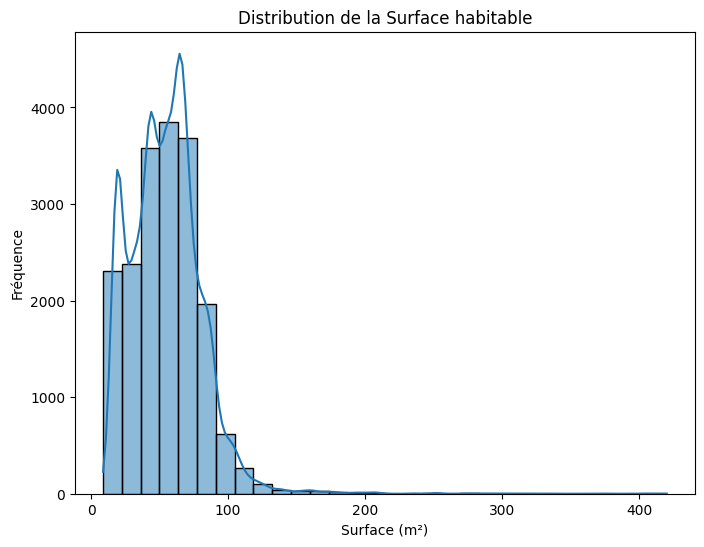

In [41]:
import matplotlib.pyplot as plt 
import seaborn as sns

sub_df = df[df['Surface_habitable_logement']<500]
plt.figure(figsize=(8, 6))
sns.histplot(sub_df['Surface_habitable_logement'], bins=30, kde=True)
plt.title('Distribution de la Surface habitable')
plt.xlabel('Surface (m²)')
plt.ylabel('Fréquence')
plt.show()

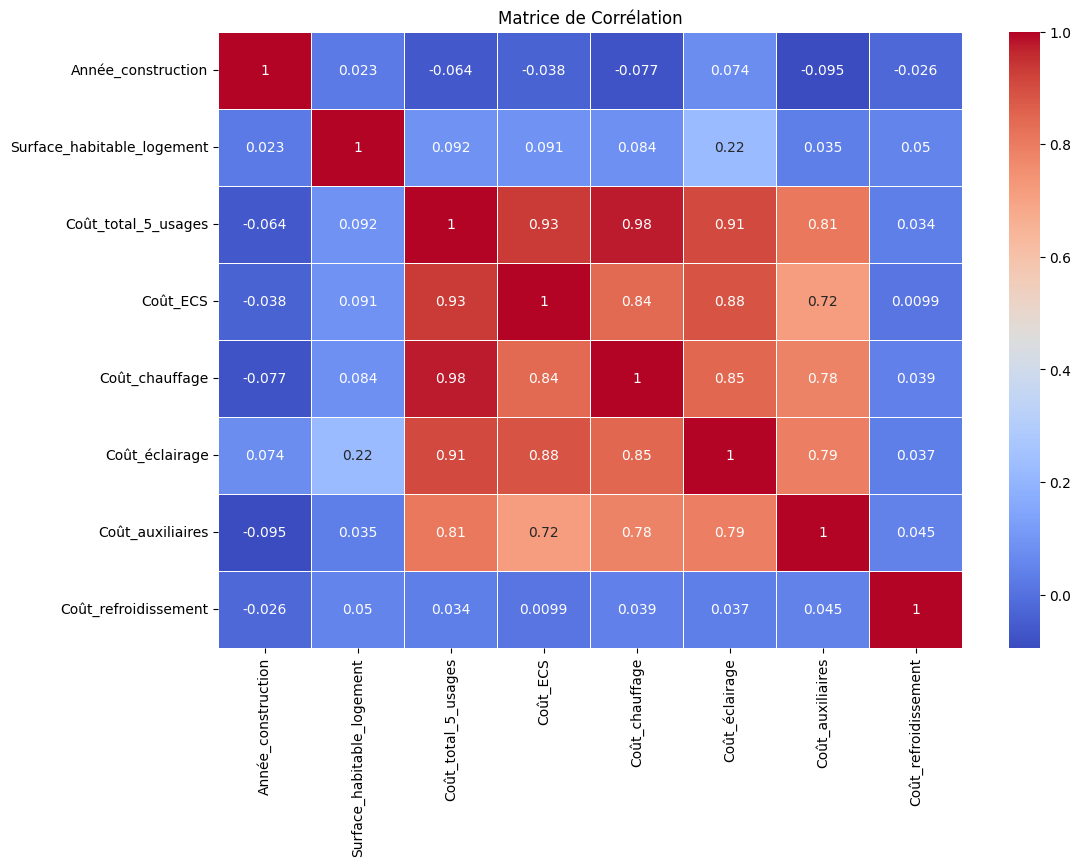

In [42]:
# Calcul de la matrice de corrélation
corr_matrix = df[variables_continues].corr()

# Affichage de la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

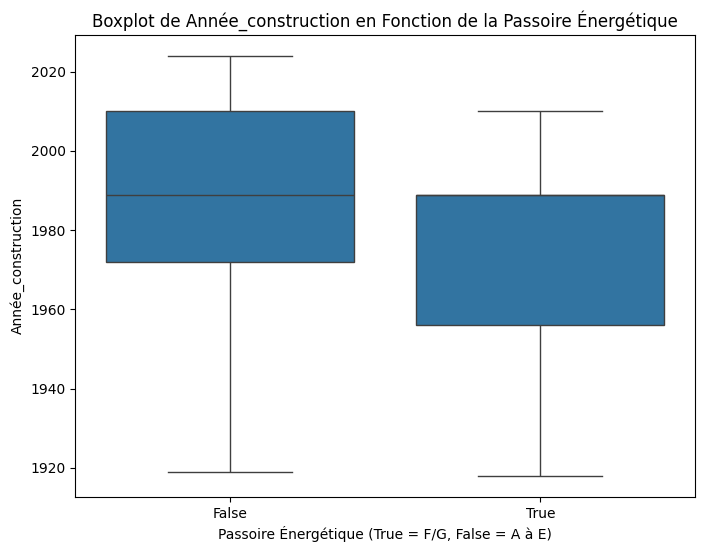

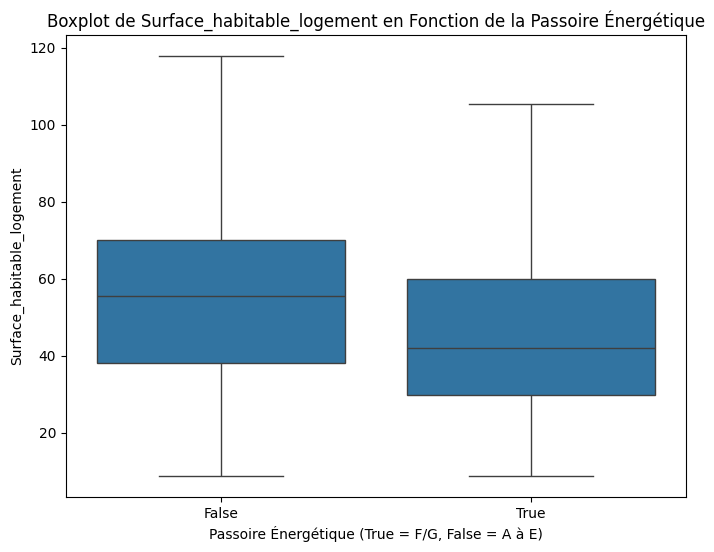

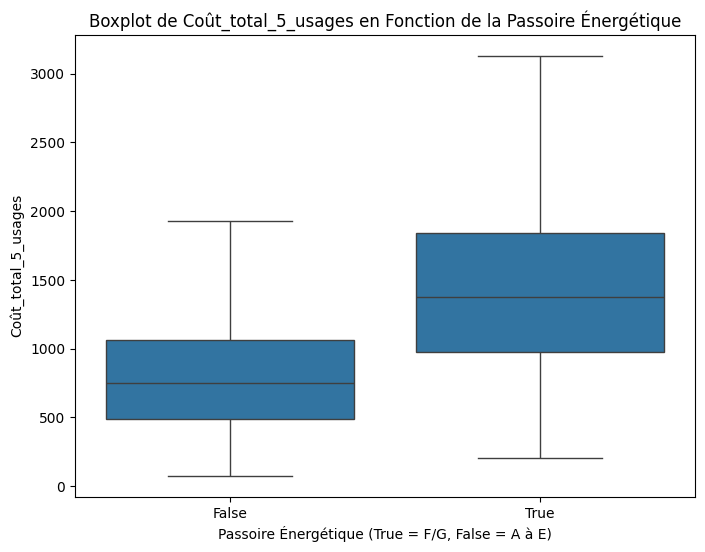

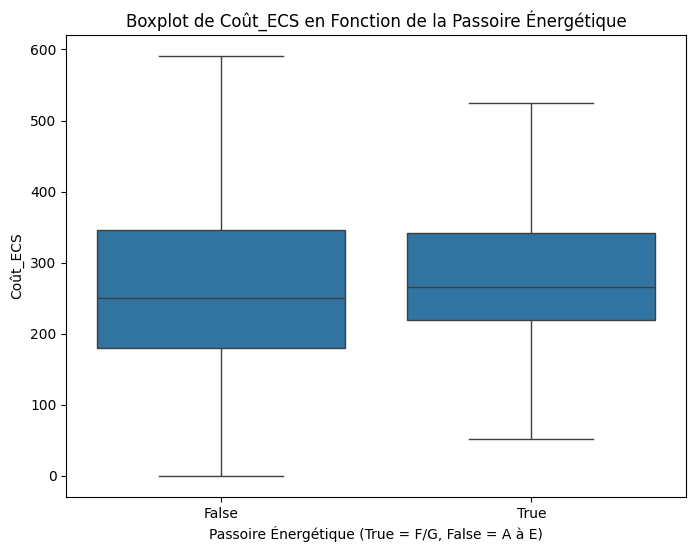

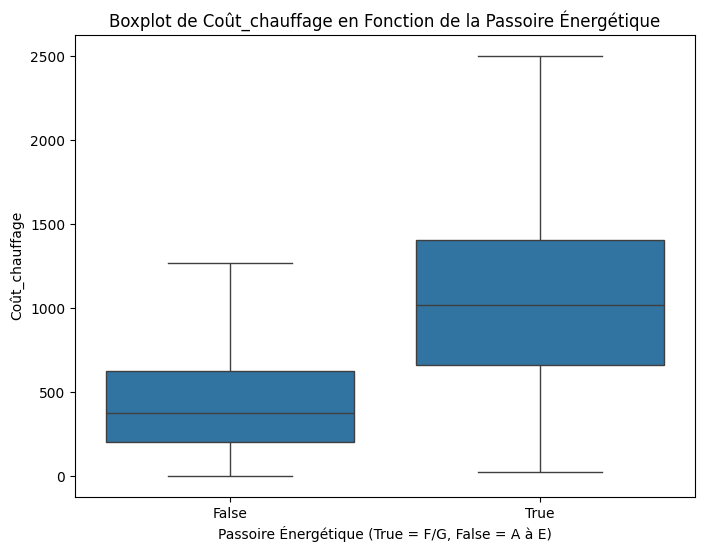

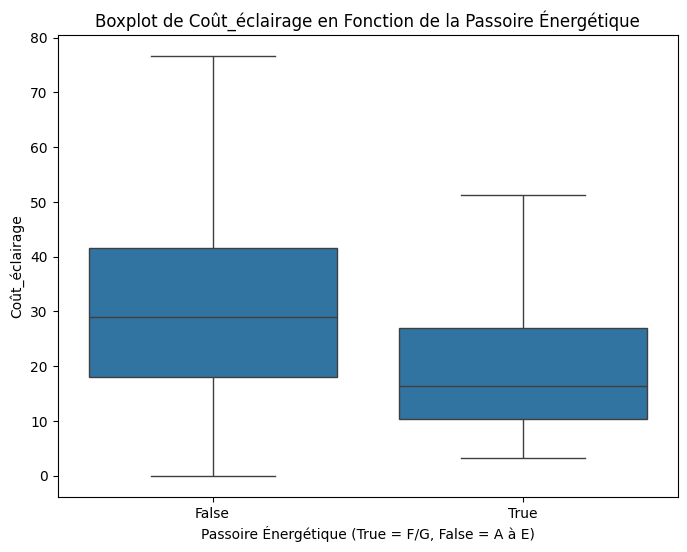

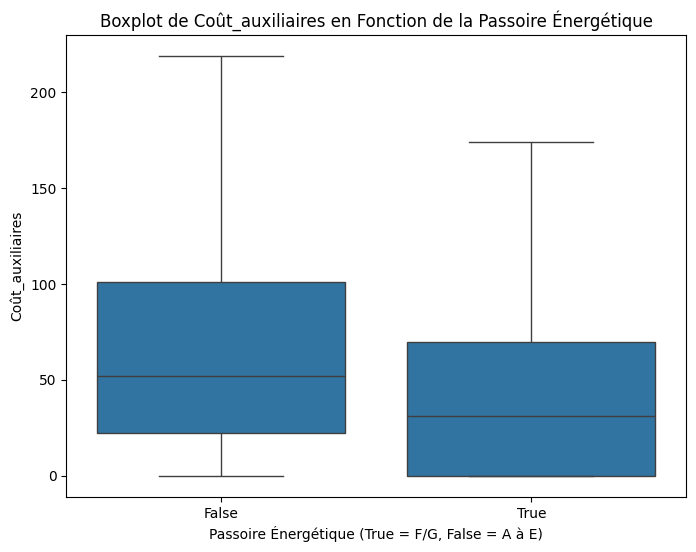

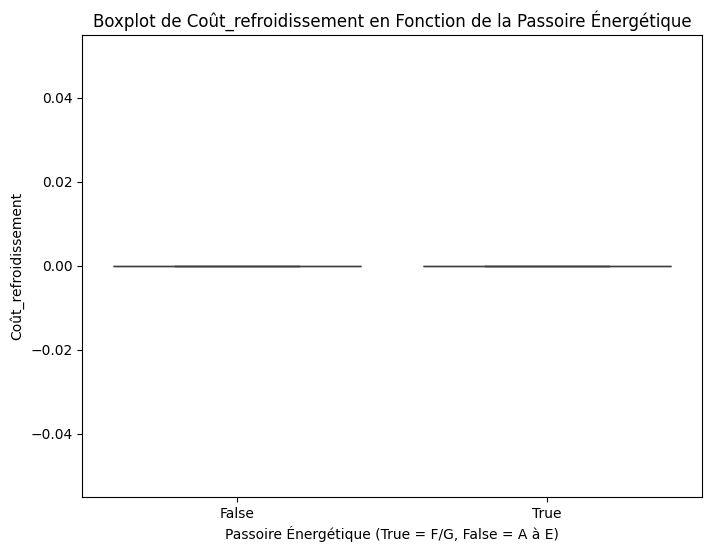

In [43]:

# Boxplot de chaque variable explicative par rapport à la passoire énergétique
for col in variables_continues:
    plt.figure(figsize=(8, 6))
    
    # Tracer le boxplot sans les outliers
    sns.boxplot(x='passoire_energetique', y=col, data=df, showfliers=False)
    
    # Automatiser le titre avec le nom de la colonne
    plt.title(f'Boxplot de {col} en Fonction de la Passoire Énergétique')
    
    plt.xlabel('Passoire Énergétique (True = F/G, False = A à E)')
    plt.ylabel(f'{col}')  # Automatiser l'étiquette de l'axe y avec le nom de la colonne
    plt.show()


In [44]:
# Concaténer les deux listes : ls_variables_explicatives et ['passoire_energetique']
df = df[ls_variables_explicatives + ['passoire_energetique']]

In [45]:
df = pd.get_dummies(df, columns=['Type_énergie_n°1'], drop_first=True)

In [46]:
df.head()

,Année_construction,Surface_habitable_logement,Coût_total_5_usages,Coût_ECS,Coût_chauffage,Coût_éclairage,Coût_auxiliaires,Coût_refroidissement,passoire_energetique,Type_énergie_n°1_Bois – Granulés (pellets) ou briquettes,Type_énergie_n°1_Bois – Plaquettes forestières,Type_énergie_n°1_Fioul domestique,Type_énergie_n°1_GPL,Type_énergie_n°1_Gaz naturel,Type_énergie_n°1_Réseau de Chauffage urbain,Type_énergie_n°1_Électricité
0,2001.000000,93.6,1090.8,325.6,694.2,30.0,40.9,0.0,False,False,False,False,False,False,False,True
1,1988.839438,32.8,643.5,226.5,267.1,21.1,128.8,0.0,False,False,False,False,False,True,False,False
2,1988.839438,78.0,2779.0,248.6,2417.1,42.1,71.2,0.0,True,False,False,False,False,True,False,False
3,1988.839438,27.8,719.0,283.4,426.1,9.4,0.0,0.0,False,False,False,False,False,False,False,True
4,1988.839438,27.6,660.6,252.0,399.0,9.5,0.0,0.0,False,False,False,False,False,False,False,True


## Echantillonnage

In [47]:
X = df[df.columns.difference(['passoire_energetique'])]

In [48]:
X = df[variables_continues]

In [49]:
Y = df["passoire_energetique"]

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.30,
                                                    stratify = Y,
                                                    random_state = 42)

In [51]:
y_train.value_counts(normalize=True)


passoire_energetique
False    0.918152
True     0.081848
Name: proportion, dtype: float64

In [52]:
y_test.value_counts(normalize=True)

passoire_energetique
False    0.918076
True     0.081924
Name: proportion, dtype: float64

In [53]:
print(X_train.shape)
print(X_test.shape)
X_test.head()

(13244, 8)
(5676, 8)


,Année_construction,Surface_habitable_logement,Coût_total_5_usages,Coût_ECS,Coût_chauffage,Coût_éclairage,Coût_auxiliaires,Coût_refroidissement
17092,2024.0,42.1,307.4,150.1,120.3,83.1,5.5,0.0
4779,1994.0,22.0,431.7,265.4,131.6,40.9,0.0,0.0
7359,2008.0,70.0,937.3,383.0,386.9,22.8,61.2,83.4
13406,1972.0,64.0,958.8,405.5,489.5,25.6,38.2,0.0
10052,1971.0,70.3,1695.0,154.6,1446.1,37.9,56.3,0.0


In [54]:
from sklearn.tree import DecisionTreeClassifier
model_arbre = DecisionTreeClassifier(max_depth=3 , min_samples_leaf=50, min_samples_split=100)
model_arbre = model_arbre.fit(X_train,y_train)

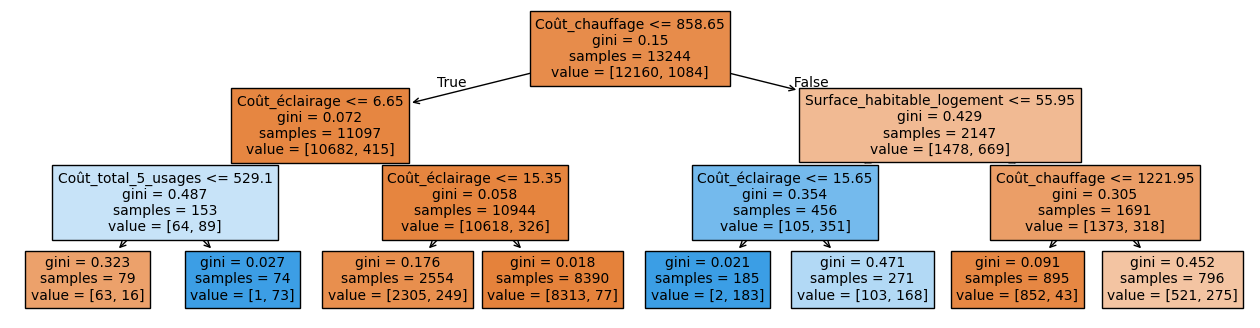

In [55]:
from sklearn.tree import plot_tree
plt.figure(figsize=(16,4))
plot_tree(model_arbre,feature_names = list(X.columns),filled=True, fontsize=10)
plt.show()

In [56]:
y_pred = model_arbre.predict(X_test)
y_pred

array([False, False, False, ..., False, False, False])

In [57]:
y_pred_proba = model_arbre.predict_proba(X_test)
y_pred_proba[0:10]

array([[0.99082241, 0.00917759],
       [0.99082241, 0.00917759],
       [0.99082241, 0.00917759],
       [0.99082241, 0.00917759],
       [0.65452261, 0.34547739],
       [0.90250587, 0.09749413],
       [0.99082241, 0.00917759],
       [0.99082241, 0.00917759],
       [0.99082241, 0.00917759],
       [0.99082241, 0.00917759]])

In [58]:
from sklearn.metrics import confusion_matrix
mc = pd.DataFrame(confusion_matrix(y_test,y_pred),
                  columns=['pred_0','pred_1'],
                  index=['obs_0','obs_1'])

mc

#ou 

pd.crosstab(y_test,y_pred, colnames=['pred'], rownames=['obs'], margins=True)

pred,False,True,All
obs,,,
False,5174,37,5211
True,296,169,465
All,5470,206,5676


In [59]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.9413319238900634


In [60]:
from sklearn.metrics import recall_score, precision_score
print('recall :' + str(recall_score(y_test,y_pred,average='binary', pos_label=0)))
print('precision : ' + str(precision_score(y_test,y_pred, average='binary', pos_label=0)))

recall :0.992899635386682
precision : 0.9458866544789762


In [61]:
from sklearn.metrics import f1_score
print('f1_score : ' + str(f1_score(y_test,y_pred, average='binary', pos_label=0)))

f1_score : 0.9688231439003838


In [62]:
print('recall : ' + str(recall_score(y_test,y_pred,average='macro')))
print('precision : ' + str(precision_score(y_test,y_pred, average='macro')))
print('f1_score : ' + str(f1_score(y_test,y_pred, average='macro')))

recall : 0.6781702478008679
precision : 0.8831375019967697
f1_score : 0.7362744631573455


In [63]:
print('recall : ' + str(recall_score(y_test,y_pred,average='weighted')))
print('precision : ' + str(precision_score(y_test,y_pred, average='weighted')))
print('f1_score : ' + str(f1_score(y_test,y_pred, average='weighted')))

recall : 0.9413319238900634
precision : 0.9356053451399255
f1_score : 0.9307205587892096


## Validation croisée

In [64]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report

model_arbre_cv = DecisionTreeClassifier(random_state=42)

cv_scores = cross_val_score(model_arbre_cv, X_train, y_train, cv=5, scoring='f1_macro')

print(f"Scores de validation croisée:{cv_scores}") # permet de savoir comment le modele prédit (surapprentissage ?)
print(f"Moyenne des scores de validation croisée : {cv_scores.mean()}")

model_arbre_cv.fit(X_train, y_train)

y_pred_arbre_cv = model_arbre.predict(X_test)

print(classification_report(y_test, y_pred_arbre_cv)) # permet d'avoir l'ensemble les scores des metriques recall, precision , f1
print(f"Accuracy sur l'ensemble de test: {accuracy_score(y_test, y_pred_arbre_cv)}")

Scores de validation croisée:[0.88101742 0.89209411 0.90166928 0.89324493 0.89589636]
Moyenne des scores de validation croisée : 0.8927844211217929
              precision    recall  f1-score   support

       False       0.95      0.99      0.97      5211
        True       0.82      0.36      0.50       465

    accuracy                           0.94      5676
   macro avg       0.88      0.68      0.74      5676
weighted avg       0.94      0.94      0.93      5676

Accuracy sur l'ensemble de test: 0.9413319238900634


In [65]:
import numpy as np 

parameters = {
    'max_depth': np.arange(start=1, stop=10, step=1),
    'min_samples_leaf': np.arange(start = 5, stop = 250, step = 50),
    'min_samples_split': np.arange(start = 10, stop = 500, step = 50)
}

In [66]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

model_arbre_grid = DecisionTreeClassifier()
score = make_scorer(f1_score, pos_label=0)
model_arbre_grid = GridSearchCV(model_arbre_grid, parameters, scoring=score, verbose=2, cv=5)
model_arbre_grid.fit(X_train, y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
[CV] END max_depth=1, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=5, min_samples_split=60; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=5, min_samples_split=60; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=5, min_samples_split=60; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=5, min_samples_split=60; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=5, min_samples_split=60; total time=   0.0s
[CV] END max_depth=1, min_samples_leaf=5, min_samples_split=110; total time=   0.0s
[CV] END max_depth=1, 

KeyboardInterrupt: 

In [67]:
print("Voici les paramètres du meilleure modèle : " + str(model_arbre_grid.best_estimator_))
print("Voici le "  + str(model_arbre_grid.scorer_) + " du meilleure modèle : " + str(model_arbre_grid.best_score_))

Voici les paramètres du meilleure modèle : DecisionTreeClassifier(max_depth=9, min_samples_leaf=5, min_samples_split=10)
Voici le make_scorer(f1_score, pos_label=0) du meilleure modèle : 0.9840180671693057


In [68]:
# Prédictions sur l'ensemble de test
y_pred_arbre_grid = model_arbre_grid.predict(X_test)

In [69]:
# Évaluation du modèle
print(classification_report(y_test, y_pred_arbre_grid))
print(f"Accuracy sur l'ensemble de test : {accuracy_score(y_test, y_pred_arbre_grid)}")
print('recall :' + str(recall_score(y_test,y_pred,average='binary', pos_label=0)))
print('precision : ' + str(precision_score(y_test,y_pred, average='binary', pos_label=0)))
print('f1_score : ' + str(f1_score(y_test,y_pred, average='binary', pos_label=0)))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98      5211
        True       0.84      0.80      0.82       465

    accuracy                           0.97      5676
   macro avg       0.91      0.89      0.90      5676
weighted avg       0.97      0.97      0.97      5676

Accuracy sur l'ensemble de test : 0.970754052149401
recall :0.992899635386682
precision : 0.9458866544789762
f1_score : 0.9688231439003838


In [70]:
# Prédire les probabilités pour la classe positive (1)
y_proba_cv = model_arbre_cv.predict_proba(X_test)[:, 1]
y_proba_grid = model_arbre_grid.predict_proba(X_test)[:, 1]

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calculer les courbes ROC
fpr1, tpr1, _ = roc_curve(y_test, y_proba_cv)
fpr2, tpr2, _ = roc_curve(y_test, y_proba_grid)

# Calculer l'AUC pour chaque modèle
auc1 = roc_auc_score(y_test, y_proba_cv)
auc2 = roc_auc_score(y_test, y_proba_grid)

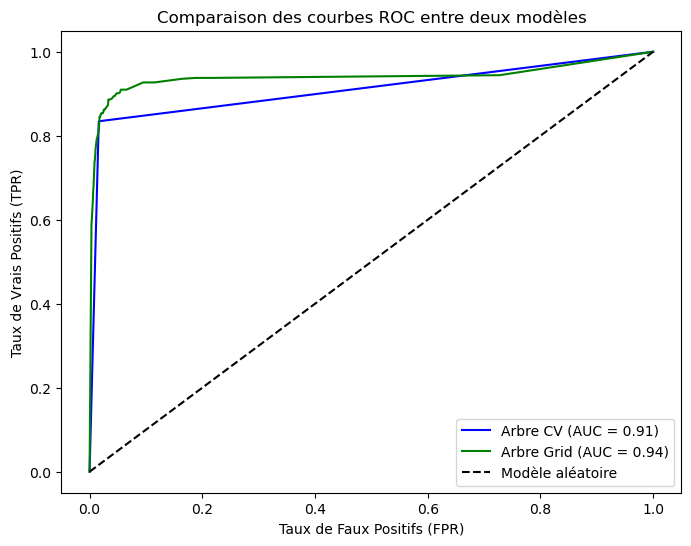

In [72]:
import matplotlib.pyplot as plt
# Tracer les courbes ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'Arbre CV (AUC = {auc1:.2f})', color='blue')
plt.plot(fpr2, tpr2, label=f'Arbre Grid (AUC = {auc2:.2f})', color='green')

# Ajouter la diagonale (aléatoire)
plt.plot([0, 1], [0, 1], 'k--', label='Modèle aléatoire')

# Ajouter des labels et un titre
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Comparaison des courbes ROC entre deux modèles')
plt.legend(loc='lower right')

# Afficher le graphique
plt.show()

## KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors = 5)
model_knn.fit(X_train, y_train)



KNeighborsClassifier()

In [74]:
y_pred_knn = model_knn.predict(X_test)

In [75]:
print('f1_score : ' + str(f1_score(y_test,y_pred_knn,average='binary', pos_label=1)))

f1_score : 0.6405693950177936


In [76]:
from sklearn.linear_model import LogisticRegression

reg_log = LogisticRegression()
reg_log_model = reg_log.fit(X_train, y_train)
y_pred_reg = reg_log_model.predict(X_test)

print('f1_score : ' + str(f1_score(y_test,y_pred_reg,average='binary', pos_label=1)))

f1_score : 0.5170278637770898


In [77]:
reg_log_model.predict_proba(X_test)[0:10]

array([[9.99710573e-01, 2.89426864e-04],
       [9.91573723e-01, 8.42627652e-03],
       [9.88540625e-01, 1.14593753e-02],
       [9.70918641e-01, 2.90813586e-02],
       [7.39380759e-01, 2.60619241e-01],
       [8.36462898e-01, 1.63537102e-01],
       [9.61211759e-01, 3.87882414e-02],
       [9.60350840e-01, 3.96491598e-02],
       [9.94152372e-01, 5.84762782e-03],
       [9.84426180e-01, 1.55738202e-02]])

In [78]:
coef = pd.DataFrame(reg_log_model.coef_[0,] ,index = X_train.columns, columns=['Coef'])
coef.loc['Constante'] = reg_log_model.intercept_
coef

,Coef
Année_construction,-0.000477
Surface_habitable_logement,-0.014933
Coût_total_5_usages,-0.009060
Coût_ECS,0.007166
Coût_chauffage,0.012508
Coût_éclairage,-0.076391
Coût_auxiliaires,0.000062
Coût_refroidissement,0.002302
Constante,0.000071


### Aller plus loin avec SMOTE pour ré équilibrer les classes

In [79]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [80]:
from imblearn.over_sampling import BorderlineSMOTE

oversample = BorderlineSMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

## Random forest

In [85]:
 
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=0)

rf_model = rf_clf.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print('f1_score: '+ str(f1_score(y_test, y_pred_rf, average='binary', pos_label=1)))

pd.crosstab(y_test, y_pred, colnames=['pred'], rownames=['obs'] , margins=True)
pd.DataFrame(rf_model.feature_importances_,
             index=X_train.columns.tolist(),
             columns=['Importances']).sort_values(by = 'Importances', ascending=False)

f1_score: 0.8466819221967962


,Importances
Coût_chauffage,0.223722
Coût_éclairage,0.198477
Coût_total_5_usages,0.194151
Surface_habitable_logement,0.179203
Coût_auxiliaires,0.076532
Coût_ECS,0.073574
Année_construction,0.050933
Coût_refroidissement,0.003408


### Aller plus loin avec SHAP pour interpréter ses modèles

In [81]:
#! pip install shap

In [86]:
import shap

# Créer un explainer basé sur le modèle Random Forest
explainer = shap.TreeExplainer(rf_model)

# Calculer les valeurs SHAP pour les données de test
shap_values = explainer.shap_values(X_test)

In [ ]:
# Expliquer la première prédiction dans le jeu de test
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


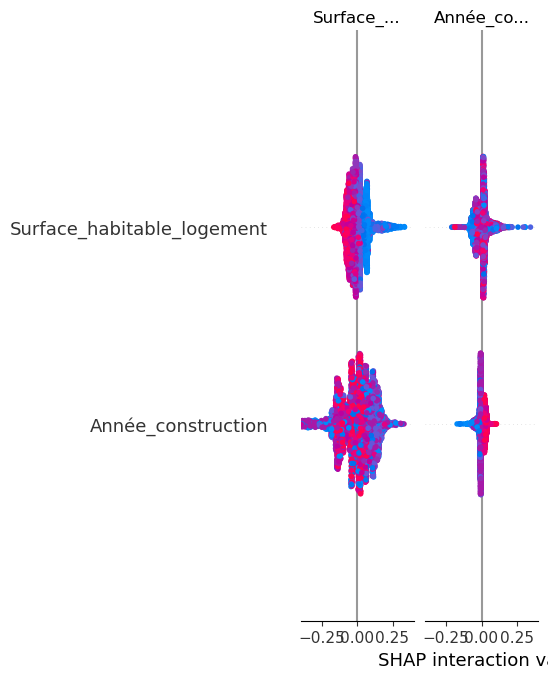

In [88]:
# Importance globale des caractéristiques (summary plot)
shap.summary_plot(shap_values, X_test)

### KNN over sampling

In [89]:
knn_smote = KNeighborsClassifier(n_neighbors=3)
knn_smote.fit(X_train_smote, y_train_smote)
y_pred_knn_smote = knn_smote.predict(X_test)

In [90]:
print('f1_score : ' + str(f1_score(y_test,y_pred_knn_smote,average='binary', pos_label=1)))

f1_score : 0.6508071367884452


In [91]:
from imblearn.over_sampling import BorderlineSMOTE

oversample = BorderlineSMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

## Regression logistique

In [92]:
from sklearn.linear_model import LogisticRegression

reg_log = LogisticRegression()
reg_log_model = reg_log.fit(X_train, y_train)
y_pred_reg = reg_log_model.predict(X_test)

print('f1_score : ' + str(f1_score(y_test,y_pred_reg,average='binary', pos_label=1)))

f1_score : 0.5170278637770898


In [93]:
reg_log_model.predict_proba(X_test)[0:10]

array([[9.99710573e-01, 2.89426864e-04],
       [9.91573723e-01, 8.42627652e-03],
       [9.88540625e-01, 1.14593753e-02],
       [9.70918641e-01, 2.90813586e-02],
       [7.39380759e-01, 2.60619241e-01],
       [8.36462898e-01, 1.63537102e-01],
       [9.61211759e-01, 3.87882414e-02],
       [9.60350840e-01, 3.96491598e-02],
       [9.94152372e-01, 5.84762782e-03],
       [9.84426180e-01, 1.55738202e-02]])

In [94]:
# les coefficient du modèle
coef = pd.DataFrame(reg_log_model.coef_[0,] ,index = X_train.columns, columns=['Coef'])
coef.loc['Constante'] = reg_log_model.intercept_
coef

,Coef
Année_construction,-0.000477
Surface_habitable_logement,-0.014933
Coût_total_5_usages,-0.009060
Coût_ECS,0.007166
Coût_chauffage,0.012508
Coût_éclairage,-0.076391
Coût_auxiliaires,0.000062
Coût_refroidissement,0.002302
Constante,0.000071


## Régression

### Variable cible

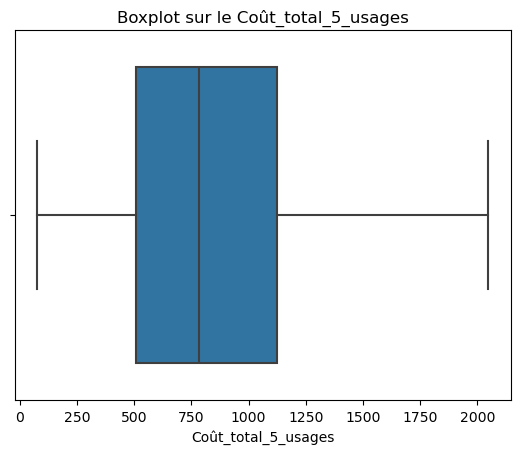

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

target = "Coût_total_5_usages"

# Créer un boxplot pour une colonne spécifique
sns.boxplot(data=df, x = target, showfliers=False)

# Afficher le graphique
plt.title(f'Boxplot sur le {target}')
plt.show()

In [96]:
import pandas as pd
import numpy as np

# Créer une séquence de 0 à 1 avec un pas de 0.1
sequence = np.arange(0, 1.1, 0.1)

# Calculer les déciles (0.1, 0.2, ..., 0.9) en ajoutant les percentiles à describe()
resultat = df[target].describe(percentiles=sequence)

In [97]:
# Changer l'option pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# Changer l'option pour afficher toutes les lignes
pd.set_option('display.max_rows', None)

## Variables explicatives

In [98]:
# Vérification des données manquantes
ls_variables_explicatives = ['Année_construction','Surface_habitable_logement','Type_énergie_n°1',
'Etiquette_DPE',
'N°_étage_appartement', 'Hauteur_sous-plafond',
'Logement_traversant_(0/1)',
'Présence_brasseur_air_(0/1)',
'Indicateur_confort_été',
'Isolation_toiture_(0/1)',
'Protection_solaire_exterieure_(0/1)',
'Inertie_lourde_(0/1)',
'Deperditions_baies_vitrées',
'Deperditions_enveloppe',
'Déperditions_murs',
'Deperditions_planchers_bas',
'Deperditions_planchers_hauts',
'Déperditions_ponts_thermiques',
'Déperditions_portes',
'Déperditions_renouvellement_air',
'Qualité_isolation_enveloppe',
'Qualité_isolation_menuiseries',
'Qualité_isolation_murs',
'Qualité_isolation_plancher_bas']

In [99]:
# Créer une séquence de 0 à 1 avec un pas de 0.1
sequence = np.arange(0, 1.1, 0.1)

# Calculer les déciles (0.1, 0.2, ..., 0.9) en ajoutant les percentiles à describe()
resultat = df.describe(percentiles=sequence)

In [100]:
# Vérification des données manquantes
df_concat[ls_variables_explicatives].isnull().sum()

Année_construction                        0
Surface_habitable_logement                0
Type_énergie_n°1                          0
Etiquette_DPE                             0
N°_étage_appartement                   4377
Hauteur_sous-plafond                      0
Logement_traversant_(0/1)              8855
Présence_brasseur_air_(0/1)            8855
Indicateur_confort_été                 8855
Isolation_toiture_(0/1)                8969
Protection_solaire_exterieure_(0/1)    8855
Inertie_lourde_(0/1)                   9079
Deperditions_baies_vitrées             2869
Deperditions_enveloppe                 2869
Déperditions_murs                      2869
Deperditions_planchers_bas             2882
Deperditions_planchers_hauts           2879
Déperditions_ponts_thermiques          2871
Déperditions_portes                    2874
Déperditions_renouvellement_air        2869
Qualité_isolation_enveloppe               0
Qualité_isolation_menuiseries             0
Qualité_isolation_murs          

In [101]:
from sklearn.impute import KNNImputer

# Sélectionner uniquement les colonnes quantitatives (numériques)
quant_cols = df_concat[ls_variables_explicatives].select_dtypes(include=[np.number]).columns

# Afficher les colonnes quantitatives
print("Colonnes quantitatives :", quant_cols)

# Initialiser le KNNImputer
imputer = KNNImputer(n_neighbors=3)

# Appliquer l'imputation sur les colonnes quantitatives
df_concat[quant_cols] = imputer.fit_transform(df_concat[quant_cols])

# Vérification des données manquantes
df_concat[quant_cols].isnull().sum()

Colonnes quantitatives : Index(['Année_construction', 'Surface_habitable_logement',
       'N°_étage_appartement', 'Hauteur_sous-plafond',
       'Logement_traversant_(0/1)', 'Présence_brasseur_air_(0/1)',
       'Isolation_toiture_(0/1)', 'Protection_solaire_exterieure_(0/1)',
       'Inertie_lourde_(0/1)', 'Deperditions_baies_vitrées',
       'Deperditions_enveloppe', 'Déperditions_murs',
       'Deperditions_planchers_bas', 'Deperditions_planchers_hauts',
       'Déperditions_ponts_thermiques', 'Déperditions_portes',
       'Déperditions_renouvellement_air'],
      dtype='object')


Année_construction                     0
Surface_habitable_logement             0
N°_étage_appartement                   0
Hauteur_sous-plafond                   0
Logement_traversant_(0/1)              0
Présence_brasseur_air_(0/1)            0
Isolation_toiture_(0/1)                0
Protection_solaire_exterieure_(0/1)    0
Inertie_lourde_(0/1)                   0
Deperditions_baies_vitrées             0
Deperditions_enveloppe                 0
Déperditions_murs                      0
Deperditions_planchers_bas             0
Deperditions_planchers_hauts           0
Déperditions_ponts_thermiques          0
Déperditions_portes                    0
Déperditions_renouvellement_air        0
dtype: int64

In [102]:
# Sélectionner toutes les colonnes non numériques (qualitatives)
categorical_cols = df_concat[ls_variables_explicatives].select_dtypes(exclude=[np.number]).columns

# Appliquer l'imputation par la valeur la plus fréquente (mode) pour chaque colonne catégorielle
for col in categorical_cols:
    df_concat[col] = df_concat[col].fillna(df_concat[col].mode()[0])

# Vérification des données manquantes
df_concat[categorical_cols].isnull().sum()

Type_énergie_n°1                  0
Etiquette_DPE                     0
Indicateur_confort_été            0
Qualité_isolation_enveloppe       0
Qualité_isolation_menuiseries     0
Qualité_isolation_murs            0
Qualité_isolation_plancher_bas    0
dtype: int64

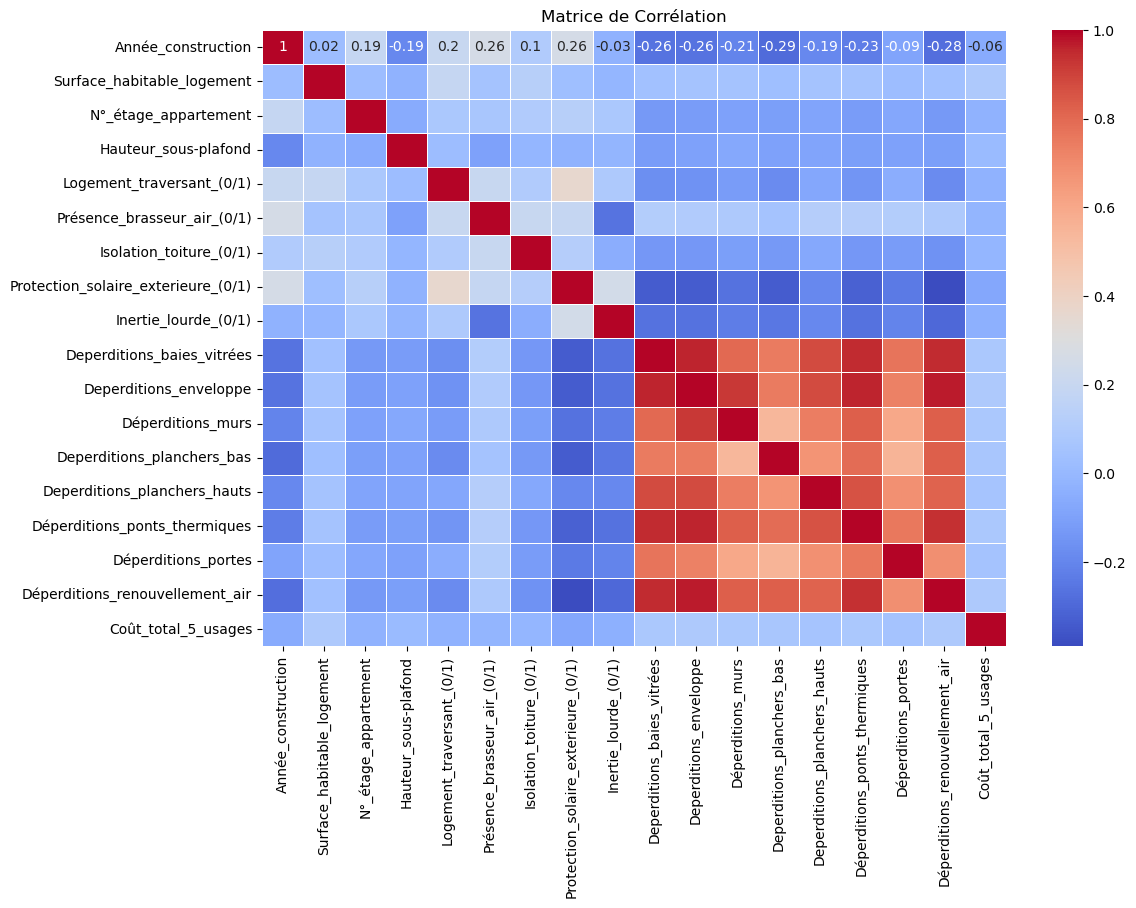

In [103]:
# Calcul de la matrice de corrélation
corr_matrix = round(df_concat[list(quant_cols) + [target] ].corr(),2)
# Affichage de la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

In [104]:
# Concaténer les deux listes : ls_variables_explicatives et target
df = df_concat[list(ls_variables_explicatives) + [target]]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

## Echantillonnage

In [105]:
# Utiliser set.difference() pour exclure la colonne cible de ls_variables_explicatives
X =df[df.columns.difference([target])]

In [106]:
Y = df[target]

In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.30,
                                                    random_state = 42)

In [108]:
print(X_train.shape)
print(X_test.shape)
X_test.head()

(13244, 44)
(5676, 44)


,Année_construction,Deperditions_baies_vitrées,Deperditions_enveloppe,Deperditions_planchers_bas,Deperditions_planchers_hauts,Déperditions_murs,Déperditions_ponts_thermiques,Déperditions_portes,Déperditions_renouvellement_air,Etiquette_DPE_B,Etiquette_DPE_C,Etiquette_DPE_D,Etiquette_DPE_E,Etiquette_DPE_F,Etiquette_DPE_G,Hauteur_sous-plafond,Indicateur_confort_été_insuffisant,Indicateur_confort_été_moyen,Inertie_lourde_(0/1),Isolation_toiture_(0/1),Logement_traversant_(0/1),N°_étage_appartement,Protection_solaire_exterieure_(0/1),Présence_brasseur_air_(0/1),Qualité_isolation_enveloppe_insuffisante,Qualité_isolation_enveloppe_moyenne,Qualité_isolation_enveloppe_très bonne,Qualité_isolation_menuiseries_insuffisante,Qualité_isolation_menuiseries_moyenne,Qualité_isolation_menuiseries_très bonne,Qualité_isolation_murs_insuffisante,Qualité_isolation_murs_moyenne,Qualité_isolation_murs_très bonne,Qualité_isolation_plancher_bas_insuffisante,Qualité_isolation_plancher_bas_moyenne,Qualité_isolation_plancher_bas_très bonne,Surface_habitable_logement,Type_énergie_n°1_Bois – Granulés (pellets) ou briquettes,Type_énergie_n°1_Bois – Plaquettes forestières,Type_énergie_n°1_Fioul domestique,Type_énergie_n°1_GPL,Type_énergie_n°1_Gaz naturel,Type_énergie_n°1_Réseau de Chauffage urbain,Type_énergie_n°1_Électricité
18457,2024.000000,26.366667,111.4,26.8,0.0,12.433333,18.5,0.0,27.333333,True,False,False,False,False,False,2.5,False,True,0.0,0.000000,1.0,0.333333,1.0,1.000000,False,False,False,False,False,True,False,False,True,False,False,True,67.7,False,False,False,False,False,True,False
5282,1988.839438,7.300000,26.9,0.0,0.0,3.000000,4.5,3.7,8.600000,False,False,False,True,False,False,2.5,False,True,0.0,0.000000,0.0,0.000000,1.0,0.000000,True,False,False,False,True,False,False,False,False,False,False,True,18.4,False,False,False,False,False,False,True
4525,1988.839438,42.400000,102.9,0.0,0.0,7.600000,13.8,0.0,39.100000,False,True,False,False,False,False,2.5,False,True,1.0,0.000000,0.0,0.000000,1.0,0.000000,False,False,True,True,False,False,True,False,False,False,False,True,69.6,False,False,False,False,False,True,False
17372,2024.000000,82.300000,0.4,41.0,29.8,160.200000,264.1,82.3,439.800000,True,False,False,False,False,False,2.5,False,True,0.0,0.333333,1.0,3.333333,1.0,0.000000,False,False,False,False,False,True,False,False,True,False,False,True,61.1,False,False,False,False,False,True,False
10504,2006.000000,1152.100000,5648.5,57.1,307.2,588.600000,972.9,14.8,2555.800000,False,True,False,False,False,False,2.7,False,True,0.0,0.000000,1.0,0.000000,1.0,0.666667,False,True,False,False,False,False,False,False,False,False,False,False,92.5,False,False,False,False,True,False,False


## Régression linéaire multiple

In [109]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model = lr_model.fit(X_train,y_train)

In [110]:
coef = pd.DataFrame(lr_model.coef_ ,index = X_train.columns, columns=['Coef'])
coef.loc['Constante'] = lr_model.intercept_
coef

,Coef
Année_construction,1.618991e+00
Deperditions_baies_vitrées,2.971337e-02
Deperditions_enveloppe,-1.423960e-01
Deperditions_planchers_bas,-7.007041e-01
Deperditions_planchers_hauts,8.372150e-02
Déperditions_murs,2.532645e-01
Déperditions_ponts_thermiques,1.488407e-01
Déperditions_portes,-6.659160e-01
Déperditions_renouvellement_air,3.608966e-01
Etiquette_DPE_B,2.686231e+02


## Evaluation de modèle

In [111]:
y_pred = lr_model.predict(X_test)
y_pred

array([-154.57273907,  938.36803371,   51.95531068, ...,  346.39413539,
       2163.2824538 ,  602.2926149 ])

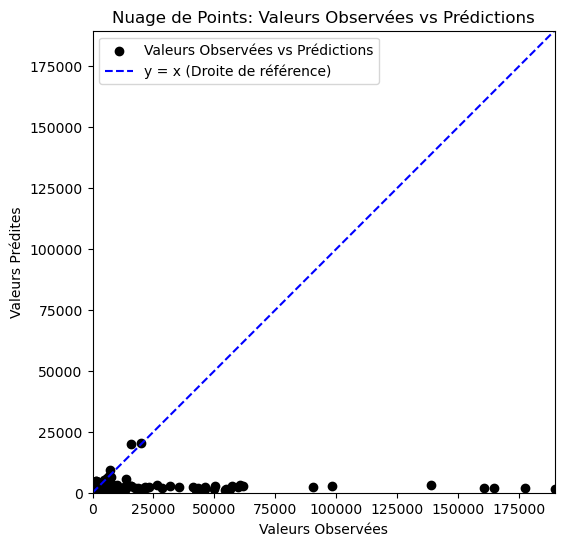

In [112]:
# Taille de la figure
plt.figure(figsize=(10, 6))

# Nuage de points pour les valeurs observées et prédites
plt.scatter(y_test, y_pred, color='black', label='Valeurs Observées vs Prédictions')

# Tracer la droite d'équation y = x
max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], color='blue', linestyle='--', label='y = x (Droite de référence)')

# Définir les limites des axes
plt.xlim(0, max_val)
plt.ylim(0, max_val)

# Assurer que les axes ont la même échelle
plt.gca().set_aspect('equal', adjustable='box')

# Ajouter des labels et une légende
plt.xlabel('Valeurs Observées')
plt.ylabel('Valeurs Prédites')
plt.title('Nuage de Points: Valeurs Observées vs Prédictions')
plt.legend()

# Afficher le graphique
plt.show()

In [113]:
from sklearn.metrics import mean_squared_error, r2_score
print("RMSE : " + str(mean_squared_error(y_test, y_pred, squared= False)))
print("R² : " + str(r2_score(y_test, y_pred)))

RMSE : 5941.421167637796
R² : 0.01830237579193328


## D'autres méthodes

### Ridge

In [114]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=0)
ridge_model = ridge_model.fit(X_train,y_train)

y_pred = ridge_model.predict(X_test)

print("RMSE : " + str(mean_squared_error(y_test, y_pred, squared= False)))
print("R² : " + str(r2_score(y_test, y_pred)))

RMSE : 52575591428.99067
R² : -76871507026021.92


In [ ]:
coef = pd.DataFrame(ridge_model.coef_ ,index = X_train.columns, columns=['Coef'])
coef.loc['Constante'] = ridge_model.intercept_
coef

In [117]:
# Modifier l'affichage global des nombres en pandas pour utiliser un format décimal avec 6 chiffres après la virgule
pd.options.display.float_format = '{:.6f}'.format

# Affichage des coefficients avec les nouvelles options
coef

,Coef
Année_construction,1.618991
Deperditions_baies_vitrées,0.029713
Deperditions_enveloppe,-0.142396
Deperditions_planchers_bas,-0.700704
Deperditions_planchers_hauts,0.083721
Déperditions_murs,0.253264
Déperditions_ponts_thermiques,0.148841
Déperditions_portes,-0.665916
Déperditions_renouvellement_air,0.360897
Etiquette_DPE_B,268.622670


In [118]:
#Tester avec plusieurs valeurs de alpha 
# Générer des valeurs d'alpha (logarithmique entre 1e-5 et 1e3)
alphas = np.logspace(-5, 3, 100)
print(alphas)

[1.00000000e-05 1.20450354e-05 1.45082878e-05 1.74752840e-05
 2.10490414e-05 2.53536449e-05 3.05385551e-05 3.67837977e-05
 4.43062146e-05 5.33669923e-05 6.42807312e-05 7.74263683e-05
 9.32603347e-05 1.12332403e-04 1.35304777e-04 1.62975083e-04
 1.96304065e-04 2.36448941e-04 2.84803587e-04 3.43046929e-04
 4.13201240e-04 4.97702356e-04 5.99484250e-04 7.22080902e-04
 8.69749003e-04 1.04761575e-03 1.26185688e-03 1.51991108e-03
 1.83073828e-03 2.20513074e-03 2.65608778e-03 3.19926714e-03
 3.85352859e-03 4.64158883e-03 5.59081018e-03 6.73415066e-03
 8.11130831e-03 9.77009957e-03 1.17681195e-02 1.41747416e-02
 1.70735265e-02 2.05651231e-02 2.47707636e-02 2.98364724e-02
 3.59381366e-02 4.32876128e-02 5.21400829e-02 6.28029144e-02
 7.56463328e-02 9.11162756e-02 1.09749877e-01 1.32194115e-01
 1.59228279e-01 1.91791026e-01 2.31012970e-01 2.78255940e-01
 3.35160265e-01 4.03701726e-01 4.86260158e-01 5.85702082e-01
 7.05480231e-01 8.49753436e-01 1.02353102e+00 1.23284674e+00
 1.48496826e+00 1.788649

c:\Users\karam\anaconda3\envs\M1lyon\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.65398e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\karam\anaconda3\envs\M1lyon\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.81024e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\karam\anaconda3\envs\M1lyon\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.20296e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\karam\anaconda3\envs\M1lyon\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.88049e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\karam\anaconda3\env

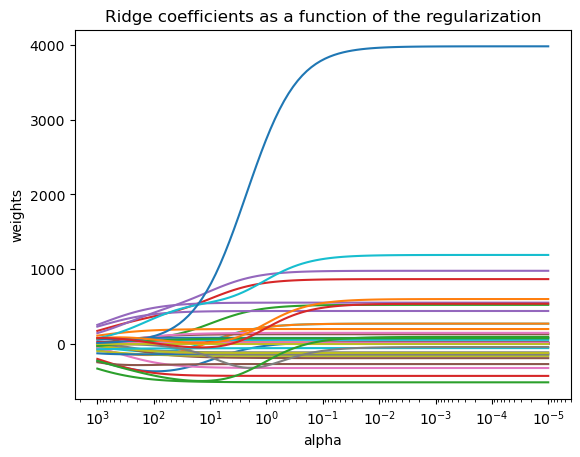

In [120]:
# Etudier l'évolution de la valeur des coefficients
# Initialiser un tableau pour stocker les coefficients
coefs = []

# Pour chaque alpha, ajuster le modèle Ridge et stocker les coefficients
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    coefs.append(ridge_model.coef_.flatten())  # Stocker les coefficients aplatis (1D)

# Convertir les coefficients en array pour pouvoir les tracer
coefs = np.array(coefs)

# Tracer les coefficients en fonction des alphas
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # Inverser l'axe pour que les alphas décroissent
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

### Lasso

In [121]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=10)
lasso_model = lasso_model.fit(X_train,y_train)

y_pred = lasso_model.predict(X_test)

print("RMSE : " + str(mean_squared_error(y_test, y_pred, squared= False)))
print("R² : " + str(r2_score(y_test, y_pred)))

RMSE : 5940.370294389266
R² : 0.018649615453298796


c:\Users\karam\anaconda3\envs\M1lyon\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e+11, tolerance: 4.352e+07
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Aplatir le coefficient du modèle pour correspondre à l'index des colonnes de X_train
coef_scaled = pd.DataFrame(lasso_model.coef_.flatten(), index=X_train.columns, columns=['Coef'])

# Ajouter l'intercept (biais) au DataFrame
coef.loc['Constante'] = lasso_model.intercept_[0]  # Si intercept_ est un tableau

# Modifier l'affichage global des nombres en pandas pour utiliser un format décimal avec 6 chiffres après la virgule
pd.options.display.float_format = '{:.6f}'.format

# Affichage des coefficients avec les nouvelles options
coef_scaled

In [125]:
coef = pd.DataFrame(lasso_model.coef_ ,
                    index = X_train.columns, columns=['Coef'])
coef.loc['Constante'] = lasso_model.intercept_
coef

,Coef
Année_construction,-1.171260
Deperditions_baies_vitrées,-0.089586
Deperditions_enveloppe,0.011124
Deperditions_planchers_bas,-0.680931
Deperditions_planchers_hauts,-0.152955
Déperditions_murs,0.107510
Déperditions_ponts_thermiques,0.014133
Déperditions_portes,-0.849623
Déperditions_renouvellement_air,0.183390
Etiquette_DPE_B,-0.000000


In [126]:
 # Générer des valeurs d'alpha (logarithmique entre 1e-5 et 1e3)
alphas = np.logspace(-5, 3, 100)
print(alphas)

[1.00000000e-05 1.20450354e-05 1.45082878e-05 1.74752840e-05
 2.10490414e-05 2.53536449e-05 3.05385551e-05 3.67837977e-05
 4.43062146e-05 5.33669923e-05 6.42807312e-05 7.74263683e-05
 9.32603347e-05 1.12332403e-04 1.35304777e-04 1.62975083e-04
 1.96304065e-04 2.36448941e-04 2.84803587e-04 3.43046929e-04
 4.13201240e-04 4.97702356e-04 5.99484250e-04 7.22080902e-04
 8.69749003e-04 1.04761575e-03 1.26185688e-03 1.51991108e-03
 1.83073828e-03 2.20513074e-03 2.65608778e-03 3.19926714e-03
 3.85352859e-03 4.64158883e-03 5.59081018e-03 6.73415066e-03
 8.11130831e-03 9.77009957e-03 1.17681195e-02 1.41747416e-02
 1.70735265e-02 2.05651231e-02 2.47707636e-02 2.98364724e-02
 3.59381366e-02 4.32876128e-02 5.21400829e-02 6.28029144e-02
 7.56463328e-02 9.11162756e-02 1.09749877e-01 1.32194115e-01
 1.59228279e-01 1.91791026e-01 2.31012970e-01 2.78255940e-01
 3.35160265e-01 4.03701726e-01 4.86260158e-01 5.85702082e-01
 7.05480231e-01 8.49753436e-01 1.02353102e+00 1.23284674e+00
 1.48496826e+00 1.788649

c:\Users\karam\anaconda3\envs\M1lyon\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.116e+11, tolerance: 4.352e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\karam\anaconda3\envs\M1lyon\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.116e+11, tolerance: 4.352e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\karam\anaconda3\envs\M1lyon\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

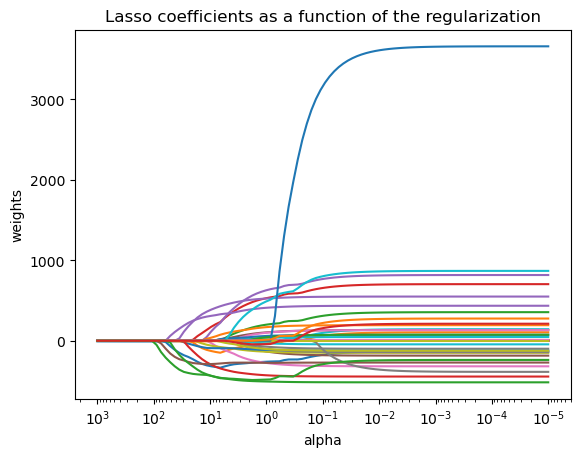

In [127]:
#Etudier l'évolution de la valeur des coefficients

# Initialiser un tableau pour stocker les coefficients
coefs = []

# Pour chaque alpha, ajuster le modèle Lasso et stocker les coefficients
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=100)  # max_iter augmenté pour assurer la convergence
    lasso_model.fit(X_train, y_train)
    coefs.append(lasso_model.coef_.flatten())  # Stocker les coefficients aplatis (1D)

# Convertir les coefficients en array pour pouvoir les tracer
coefs = np.array(coefs)

# Tracer les coefficients en fonction des alphas
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # Inverser l'axe pour que les alphas décroissent
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

## Elasticnet

In [ ]:
from sklearn.linear_model import ElasticNet

# Générer des valeurs d'alpha (logarithmique entre 1e-5 et 1e3)
alphas = np.logspace(-5, 3, 100)

# Initialiser un tableau pour stocker les coefficients
coefs = []

# Paramètre l1_ratio : ici on peut choisir une valeur qui balance Lasso et Ridge (par exemple 0.5)
l1_ratio = 0.5  # L1 et L2 sont équilibrés

# Pour chaque alpha, ajuster le modèle ElasticNet et stocker les coefficients
for alpha in alphas:
    elasticnet_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)  # max_iter pour convergence
    elasticnet_model.fit(X_train, y_train)
    coefs.append(elasticnet_model.coef_.flatten())  # Stocker les coefficients aplatis (1D)

# Convertir les coefficients en array pour pouvoir les tracer
coefs = np.array(coefs)

# Tracer les coefficients en fonction des alphas
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # Inverser l'axe pour que les alphas décroissent
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("ElasticNet coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

## Arbre de régression

In [129]:
#Modéliser avec un arbre de régression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

tree_model = DecisionTreeRegressor(max_depth = 40,min_samples_split = 2, min_samples_leaf = 1)

tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)
print("RMSE : " + str(mean_squared_error(y_test, y_pred, squared= False)))
print("MAE : " + str(mean_absolute_error(y_test, y_pred)))

# Aplatir y_test_scaled pour le rendre 1D
y_test_scaled = y_test.flatten()  # Transforme en vecteur 1D

# Affichage du scatterplot
sns.scatterplot(x=y_test_scaled, y=y_pred, legend=None)
plt.title(f'Decision Tree Regressor: R2 = {r2_score(y_test_scaled, y_pred):.3f}')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.show()

# Affichage des autres métriques
print("R2 : " + str(r2_score(y_test_scaled, y_pred)))
print("RMSE : " + str(mean_squared_error(y_test_scaled, y_pred, squared=False)))
print("MAE : " + str(mean_absolute_error(y_test_scaled, y_pred)))

RMSE : 1754.9862415288085
MAE : 189.66790321409397


AttributeError: 'Series' object has no attribute 'flatten'

In [ ]:
#Afficher l'arbre de régression
from sklearn.tree import export_graphviz
import graphviz

# Exporter l'arbre au format DOT
dot_data = export_graphviz(tree_model, out_file=None, 
                           feature_names=X_train.columns,  
                           filled=True, rounded=True,  
                           special_characters=True)  
# Visualiser avec graphviz
graph = graphviz.Source(dot_data)  
graph.render("tree_model", format="png", view=True)  # Sauvegarder et ouvrir l'arbre

## Forêt aléatoire pour la régression

In [ ]:
#Modéliser avec des forêts aléatoires
from sklearn.ensemble import RandomForestRegressor

# Créer et entraîner un modèle de forêt aléatoire
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Calcul des métriques
print("RMSE : " + str(mean_squared_error(y_test, y_pred, squared=False)))
print("MAE : " + str(mean_absolute_error(y_test, y_pred)))
print("R2 : " + str(r2_score(y_test, y_pred)))

# Aplatir y_test_scaled pour le rendre 1D
y_test = y_test_scaled.flatten()  # Transforme en vecteur 1D

# Affichage du scatterplot
sns.scatterplot(x=y_test, y=y_pred, legend=None)
plt.title(f'Random Forest Regressor: R2 = {r2_score(y_test, y_pred):.3f}')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.show()

In [ ]:
#Analyser les variables pertinentes

# Extraire les importances des variables
importances = rf_model.feature_importances_

# Créer un DataFrame avec les importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Trier les variables par importance (en ordre décroissant)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Affichage de l'importance des variables
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importance des Variables dans la Forêt Aléatoire')
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.show()

# Afficher le DataFrame des importances
print(importance_df)